# ArcFace Loss with gluon

## Imports

In [1]:
import os

c = False
while not c:
    d = os.getcwd().split('/')
    if d[-1] != 'ZHAW_deep_voice':
        os.chdir('..')
    else:
        c = True


import numpy as np
import mxnet as mx
import time
import math
import matplotlib.pyplot as plt

from mxnet.gluon import nn
from mxnet.gluon import rnn
from mxnet.metric import Accuracy, TopKAccuracy, CompositeEvalMetric, check_label_shapes

from networks.lstm_arc_face.data_generator import load_data, get_iter

from common.utils.paths import *

In [2]:
class CrossEntropy(mx.metric.EvalMetric):
    def __init__(self, eps=1e-12, name='cross-entropy', output_names=None, label_names=None):
        super(CrossEntropy, self).__init__(name, eps=eps,output_names=output_names, label_names=label_names)
        self.eps = eps

    def update(self, labels, preds):
        labels, preds = check_label_shapes(labels, preds, True)
        for label, pred in zip(labels, preds):
            pred = mx.nd.softmax(pred, axis=1)
            label = label.asnumpy()
            pred = pred.asnumpy()

            label = label.ravel()
            assert label.shape[0] == pred.shape[0]
            prob = pred[np.arange(label.shape[0]), np.int64(label)]
            self.sum_metric += (-np.log(prob + self.eps)).sum()
            self.num_inst += label.shape[0]

## Optimizer

In [3]:
lr = 0.001
lr_factor = 0.1
lr_steps = [50, 80, 100, 150, 200, 300]
wd = 0.0001
momentum = 0.9


def get_trainer(net):
    global lr, wd, momentum
    kv = mx.kv.create('device')
    trainer = mx.gluon.Trainer(net.collect_params(), 'sgd',
                               optimizer_params={'learning_rate': lr,
                                                 'wd': wd,
                                                 'momentum': momentum,
                                                 'multi_precision': True},
                               kvstore=kv)
    
    trainer = mx.gluon.Trainer(net.collect_params(), mx.optimizer.AdaDelta(), kvstore=kv)
    return trainer

def update_learning_rate(trainer, epoch):
    global lr, lr_factor, lr_steps
    
    new_lr = lr * (lr_factor ** int(np.sum(np.array(lr_steps) < epoch)))
    trainer.set_learning_rate(new_lr)
    return trainer

## Models

In [4]:
class NetworkBlock(mx.gluon.HybridBlock):
    def __init__(self, n_classes, **kwargs):
        super(NetworkBlock, self).__init__(**kwargs)

        self.lstm_hidden_1 = 256
        self.lstm_hidden_2 = 256
        self.dense_hidden_1 = n_classes * 10
        self.dense_hidden_2 = n_classes * 5
        self.drop_rate_1 = 0.5
        self.drop_rate_2 = 0.25

        self.output_size = self.dense_hidden_2

        with self.name_scope():
            self.body = nn.HybridSequential(prefix='')
            self.body.add(rnn.LSTM(self.lstm_hidden_1, bidirectional=True))
            self.body.add(nn.Dropout(self.drop_rate_1))
            self.body.add(rnn.LSTM(self.lstm_hidden_2, bidirectional=True))
            self.body.add(nn.Dense(self.dense_hidden_1))
            self.body.add(nn.Dropout(self.drop_rate_2))
            self.body.add(nn.Dense(self.dense_hidden_2))

    def hybrid_forward(self, F, x):
        x = self.body(x)
        return x

In [5]:
class ArcFaceBlock(mx.gluon.HybridBlock):
    def __init__(self, n_classes, **kwargs):
        super(ArcFaceBlock, self).__init__(**kwargs)
        #self.s = 64.0
        self.s = 1.0
        self.arcface_m = 0.3
        
        #self.cosface_m = 0.2
        self.cosface_m = 0.0
        
        self.easy_margin = True
        
        self.cos_m = math.cos(self.arcface_m)
        self.sin_m = math.sin(self.arcface_m)
        
        self.th = math.cos(math.pi - self.arcface_m)
        self.mm = math.sin(math.pi - self.arcface_m) * self.arcface_m
        
        self.n_classes = n_classes
        with self.name_scope():
            self.body = nn.HybridSequential(prefix='')
            network_block = NetworkBlock(self.n_classes)
            self.body.add(network_block)
            self.last_fc_weight = self.params.get('last_fc_weight', shape=(self.n_classes, network_block.output_size))

    def hybrid_forward(self, F, x, label, last_fc_weight):
        embeddings = self.body(x)

        n_embeddings = F.L2Normalization(embeddings, mode='instance')
        n_weights = F.L2Normalization(last_fc_weight, mode='instance')
        last_fc = F.FullyConnected(n_embeddings, n_weights,
                                   no_bias = True, flatten=True,
                                   num_hidden=self.n_classes,
                                   name='last_fc')
        
        cos_theta = last_fc / self.s
        sin_theta = F.sqrt(1 - cos_theta ** 2)
        phi = cos_theta * self.cos_m - sin_theta * self.sin_m
        phi = phi - self.cosface_m
        
        if self.easy_margin:
            phi = F.where(cos_theta > 0, phi, cos_theta)
        else:
            phi = F.where(cos_theta > self.th, phi, cos_theta - self.mm)
        # convert label to one-hot
        one_hot = F.one_hot(label, depth=self.n_classes)
        # where(out_i = {x_i if condition_i else y_i)
        output = one_hot * phi + (1.0 - one_hot) * cos_theta
        output = output * self.s
        return output, last_fc

In [6]:
class ArcFaceBlock(mx.gluon.HybridBlock):
    def __init__(self, n_classes, **kwargs):
        super(ArcFaceBlock, self).__init__(**kwargs)
        self.s = 1.0
        self.m1 = 1.0
        self.m2 = 0.3
        self.m3 = 0.2
        self.n_classes = n_classes
        with self.name_scope():
            self.body = nn.HybridSequential(prefix='')
            network_block = NetworkBlock(self.n_classes)
            self.body.add(network_block)
            self.last_fc_weight = self.params.get('last_fc_weight', shape=(self.n_classes, network_block.output_size))

    def hybrid_forward(self, F, x, label, last_fc_weight):
        embeddings = self.body(x)

        norm_embeddings = F.L2Normalization(embeddings, mode='instance')
        norm_weights = F.L2Normalization(last_fc_weight, mode='instance')
        last_fc = F.FullyConnected(norm_embeddings, norm_weights, no_bias = True,
                                       num_hidden=self.n_classes, name='last_fc')

        original_target_logit = F.pick(last_fc, label, axis=1)
        theta = F.arccos(original_target_logit / self.s)
        if self.m1!=1.0:
            theta = theta*self.m1
        if self.m2>0.0:
            theta = theta+self.m2
        marginal_target_logit = F.cos(theta)
        if self.m3>0.0:
            marginal_target_logit = marginal_target_logit - self.m3
        gt_one_hot = F.one_hot(label, depth = self.n_classes, on_value = 1.0, off_value = 0.0)
        diff = marginal_target_logit - original_target_logit
        diff = diff * self.s
        diff = F.expand_dims(diff, 1)
        body = F.broadcast_mul(gt_one_hot, diff)
        out = last_fc + body
        return out, last_fc

## Testing

In [7]:
def test(net, ctx, val_data, metric, loss):
    metric.reset()
    l = []
    for batch in val_data:
        data = mx.gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
        label = mx.gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        cur_l = []
        for X, y in zip(data, label):
            z, ze = net(X, y)
            L = loss(z, y)
            cur_l.append(np.mean(L.asnumpy()))
        l.append(np.mean(np.array(cur_l)))
        outputs = [net(X, y)[-1] for X, y in zip(data, label)]
        metric.update(label, outputs)
    name, indices = metric.get()
    return name, indices, np.mean(np.array(l))

def epoch_callback(net, epoch, time, metric, ctx, val_iter, loss, verbose=True):
    name, indices = metric.get()
    t_acc = indices[0]
    text1 = ('[Epoch %d]\t'%epoch)+'training:'
    for i in range(len(name)):
        text1 += '\t%s=%.6f'%(name[i],indices[i])
    name, indices, L = test(net, ctx, val_iter, metric, loss)
    v_acc = indices[0]
    text2 = ('[Epoch %d]\t'%epoch)+'validation:'
    for i in range(len(name)):
        text2 += '\t%s=%.6f'%(name[i],indices[i])
    if verbose:
        print('[Epoch %d]\ttime used:\t%f'%(epoch, time))
        print(text1)
        print(text2)
        print()
    return t_acc, v_acc, L

## Training

In [8]:
%matplotlib notebook
def train(train_data_path, batch_size, batches_per_epoch, max_epochs):
    ctx = []
    cvd = os.environ['CUDA_VISIBLE_DEVICES'].strip()
    if len(cvd) > 0:
        for i in range(len(cvd.split(','))):
            ctx.append(mx.gpu(i))
    if len(ctx) == 0:
        ctx = [mx.cpu()]
    
    metric = CompositeEvalMetric([Accuracy(), TopKAccuracy(5), CrossEntropy()])
    train_iter, val_iter, num_speakers = load_data(train_data_path, batch_size, batches_per_epoch)

    net = ArcFaceBlock(num_speakers)
    net.hybridize()
    net.initialize(mx.init.Xavier())
    net.collect_params().reset_ctx(ctx)

    trainer = get_trainer(net)
    
    loss = mx.gluon.loss.SoftmaxCrossEntropyLoss()
    
    t_accs = []
    v_accs = []
    
    fig = plt.figure()
    train_ax = fig.add_subplot(211)
    val_ax = fig.add_subplot(212)
    plt.ion()

    fig.show()
    fig.canvas.draw()
    
    xs = []
    epoch = 0
    total_time = 0
    best_val_acc = 0
    best_train_acc = 0
    t_losses = []
    v_losses = []
    with open('accs.csv', 'w+') as file:
        file.write('epoch, train_acc, val_acc\n')
    while epoch < max_epochs:
        train_iter.reset()
        val_iter.reset()
        metric.reset()
        #trainer = update_learning_rate(trainer, epoch)
        start = time.time()
        cur_l = []
        for i, batch in enumerate(train_iter):
            x = batch.data[0]
            y = batch.label[0]
            outputs = []
            outputs_eval = []
            Ls = []
            with mx.autograd.record():
                z, ze = net(x, y)
                L = loss(z, y)
                Ls.append(L)
                outputs.append(z)
                outputs_eval.append(ze)
                mx.autograd.backward(Ls)
                
                cur_l.append(np.mean(L.asnumpy()))
            
            trainer.step(batch.data[0].shape[0])
            
            metric.update([y], outputs_eval)
            
        t_losses.append(np.mean(np.array(cur_l)))
        epoch_time = time.time() - start
        total_time += epoch_time
        t_acc, v_acc, v_l = epoch_callback(net, epoch, epoch_time, metric, ctx, val_iter, loss, verbose=False)
        v_losses.append(v_l)
        if t_acc > best_train_acc:
            best_train_acc = t_acc
            net.save_parameters('best_train_acc')
        if v_acc > best_val_acc:
            best_val_acc = v_acc
            net.save_parameters('best_val_acc')
        xs.append(epoch)
        t_accs.append(t_acc)
        v_accs.append(v_acc)
        
        train_ax.clear()
        train_ax.plot(xs, t_accs, xs, v_accs)
        train_ax.set_ylim(0,1)
        val_ax.clear()
        val_ax.plot(xs, t_losses, xs, v_losses)
        fig.canvas.draw()
        
        with open('accs.csv', 'a') as file:
            file.write('%d,%f,%f\n'%(epoch, t_acc, v_acc))
        epoch = epoch + 1

    net.save_parameters('final_epoch')
    print('Average epoch time: {}'.format(float(total_time)/(epoch - 1)))

<IPython.core.display.Javascript object>


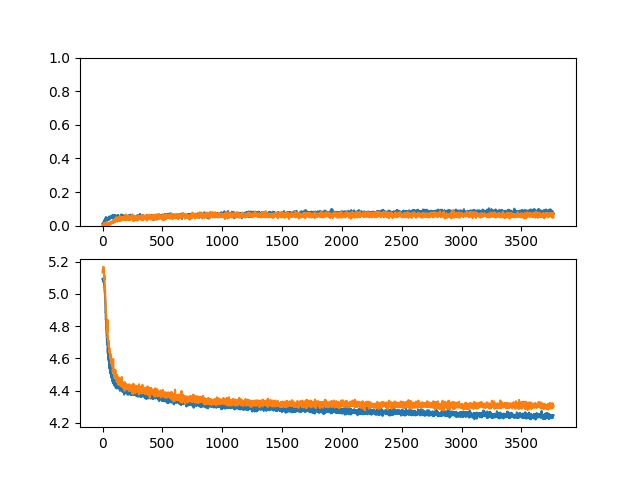

In [ ]:
train_data_path = get_speaker_pickle('speakers_100_50w_50m_not_reynolds_cluster')
max_epochs = 100000
batch_size = 128
batches_per_epoch = 10

train(train_data_path, batch_size, batches_per_epoch, max_epochs)

In [ ]:
val_data_name = 'speakers_40_clustering_vs_reynolds'